# Setup

In [ ]:
import gymnasium as gym
import babybot01_env
from tqdm import tqdm
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback, CallbackList
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from stable_baselines3.common.monitor import Monitor
from torch.utils.tensorboard import SummaryWriter
import time


name = 'ppo_1_spidy_v4_4'
env_id = "Spidy-v4_4"
n_steps = 2500
n_envs = 1
exposed_phases_indexes = [0,65]

policy = 'MlpPolicy'
tensorboard_log = f"./{name}/t_logs/"
path = f"./{name}/model/{name}"
log_path = f"./{name}/logs/"
device = 'cpu'

def make_env(render_mode:str=None):
    e = gym.make(env_id, max_episode_steps=n_steps, exposed_phases_indexes= exposed_phases_indexes, render_mode=render_mode)
    return e

: 

# Test action

In [2]:
env = gym.make(env_id,max_episode_steps=n_steps, exposed_phases_indexes = exposed_phases_indexes, render_mode="human", debug_mode=True)
obs, info = env.reset()

print(f"First Obs: {obs}")
print(f"First Phases biases: {info['phase_biases']}")

action = [0.5, 0.5]
obs, rew, terminated, truncated, info = env.step(action)

print(f"Second Obs: {obs}")
print(f"Second Phases biases: {info['phase_biases']}")

env.close()


NameError: name 'gym' is not defined

# Test Env

In [2]:


env = gym.make(env_id,max_episode_steps=n_steps, exposed_phases_indexes = exposed_phases_indexes, render_mode="human", debug_mode=True)
obs, info = env.reset()


for t in range(5000):
    
    action = 0
    obs, rew, terminated, truncated, info = env.step(action)
    print(f"obs: {obs}")
    print(f"rew: {rew}")
    print(f"t: {t}")
    print(f"proximity_reward: {info['proximity_reward']}, alignement_reward: {info['alignement_reward']}")
    print(f"terminate: {terminated}, truncated: {truncated}")

env.close()

pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) UHD Graphics 620 (KBL GT2)
GL_VERSION=4.6 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Intel
Renderer = Mesa Intel(R) UHD Graphics 620 (KBL GT2)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubu

KeyboardInterrupt: 

# Create agent

In [8]:
train_env = gym.make(env_id, exposed_phases_indexes=exposed_phases_indexes, render_mode="rgb_array", max_episode_steps=1000)

model = PPO(policy, train_env, batch_size = 60, verbose=0, n_steps=n_steps, tensorboard_log=tensorboard_log,
 ent_coef=0           
)



model.save(path)

/home/dorvan/Documents/dorvan/Babydoll/Produits/Babybot-01/Informatic-01/venv/hostEnv/lib/python3.10/site-packages/stable_baselines3/common/save_util.py:284: UserWarning: Path 'ppo_1_spidy_v4_4/model' does not exist. Will create it.
  warnings.warn(f"Path '{path.parent}' does not exist. Will create it.")


# Train

In [ ]:
class ActionLoggerCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(ActionLoggerCallback, self).__init__(verbose)
        self.writer = None

    def _on_training_start(self) -> None:
        # Initialize TensorBoard writer
        self.writer = SummaryWriter(log_dir=self.logger.dir)

    def _on_step(self) -> bool:
        # Get the actions from the rollout buffer
        actions = self.locals['actions']  # PPO stores actions here
        if actions is not None:
            actions_mean = np.mean(actions)
            actions_std = np.std(actions)
            self.writer.add_scalar("policy/actions_mean", actions_mean, self.num_timesteps)
            self.writer.add_scalar("policy/actions_std", actions_std, self.num_timesteps)
        return True

class InfoCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)
        self.log_freq = 100

    def _on_step(self) -> bool:
        # Access the training environment's 'step_info' attribute
        if self.num_timesteps % self.log_freq == 0:
            info = self.locals['infos']
            info = info[0]
            
            self.logger.record("exposed_phases_biases/phase_0", info["exposed_phases_biases"][0])
            self.logger.record("exposed_phases_biases/phase_65", info["exposed_phases_biases"][1])
            self.logger.record("rewards/proximity_reward", info["proximity_reward"])
            self.logger.record("rewards/alignement_reward", info["alignement_reward"])

            actions = self.locals["actions"][0]
            self.logger.record("actions", actions)

            self.logger.dump(step=self.num_timesteps)
        
        return True
            
train_env = Monitor(make_env())
eval_env = Monitor(make_env())

eval_callback = EvalCallback(eval_env,
                             log_path=log_path, eval_freq=1e3,
                             deterministic=True, render=False)

class SaveOnStep(BaseCallback):
    def __init__(self, steps: int, path: str):
        super().__init__()
        self.steps = steps
        self.save_path = path

    def _on_step(self) -> bool:
        # Check if the current step matches the saving frequency
        if self.n_calls % self.steps == 0:
            # Save model with the current timestep in the filename

            print(f"Saving model at step {self.n_calls} to {self.save_path}")
            self.model.save(self.save_path)
        return True
    
callbacks = [
    SaveOnStep(1e4, path), 
    InfoCallback(), 
    ActionLoggerCallback(),
    #eval_callback
    ]

model = PPO.load(path,train_env ,device=device)

model.learn(total_timesteps=6e5, progress_bar=True, callback=callbacks, reset_num_timesteps=False)

model.save(path)

train_env.close()


Output()

KeyboardInterrupt: 

# Display

In [ ]:

test_env = gym.make(env_id,max_episode_steps=n_steps,exposed_phases_indexes=exposed_phases_indexes, render_mode="human", )
model = PPO.load(path)
info = {}

for episode in range(1):

    done = False
    obs, info = test_env.reset()
    for t in range(n_steps):

        action = model.predict(obs)[0]
        
        obs, reward, terminate, trunc, info = test_env.step(action)
    
        if terminate or trunc:
            break

        print(f"t: {t}, Obs: {np.array_str(obs, precision=2)}, Action: {np.array_str(action, precision=2)}, Rew: {reward:.2f} ")

test_env.close()




pybullet build time: Nov 28 2023 23:45:17


startThreads creating 1 threads.
starting thread 0
started thread 0 
argc=2
argv[0] = --unused
argv[1] = --start_demo_name=Physics Server
ExampleBrowserThreadFunc started
X11 functions dynamically loaded using dlopen/dlsym OK!
X11 functions dynamically loaded using dlopen/dlsym OK!
Creating context
Created GL 3.3 context
Direct GLX rendering context obtained
Making context current
GL_VENDOR=Intel
GL_RENDERER=Mesa Intel(R) UHD Graphics 620 (KBL GT2)
GL_VERSION=4.6 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
GL_SHADING_LANGUAGE_VERSION=4.60
pthread_getconcurrency()=0
Version = 4.6 (Core Profile) Mesa 23.2.1-1ubuntu3.1~22.04.2
Vendor = Intel
Renderer = Mesa Intel(R) UHD Graphics 620 (KBL GT2)
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubuntu
ven = Intel
Workaround for some crash in the Intel OpenGL driver on Linux/Ubu

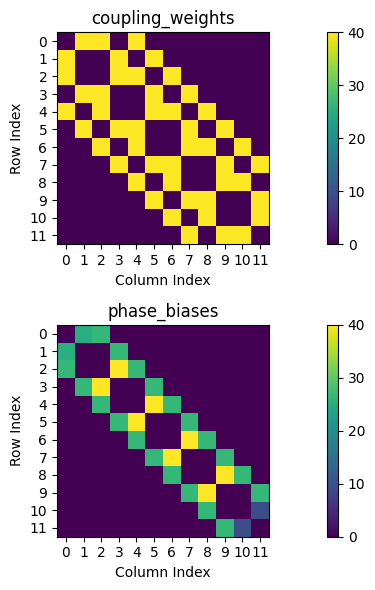

In [5]:
# Show CPG parameters
coupling_weights = info['coupling_weights']
phase_biases= info['phase_biases']



fig, axs = plt.subplots(2,1, figsize=(12, 6))  # Adjust size if needed

im1 = axs[0].imshow(coupling_weights, cmap='viridis', aspect='equal')
fig.colorbar(im1, ax=axs[0], orientation='vertical')  # Add a color bar for reference
axs[0].set_title("coupling_weights")
axs[0].set_xlabel("Column Index")
axs[0].set_ylabel("Row Index")
axs[0].set_xticks(range(12))
axs[0].set_yticks(range(12))

im2 = axs[1].imshow(phase_biases, cmap='viridis', aspect='equal')
fig.colorbar(im1, ax=axs[1], orientation='vertical')  # Add a color bar for reference
axs[1].set_title("phase_biases")
axs[1].set_xlabel("Column Index")
axs[1].set_ylabel("Row Index")
axs[1].set_xticks(range(12))
axs[1].set_yticks(range(12))


plt.tight_layout()
plt.show()